# Main visualisations bottom of Notebook
#### Sandbox Notebook for Medium article at
https://medium.com/@cjc.schmidt/approaching-unbalanced-datasets-using-data-augmentation-8b4978e1cf2e

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC


In [2]:
path = pathlib.Path.cwd()
#visualisation folder
modeldir = path / 'jpg'
if not modeldir.exists():
    modeldir.mkdir(parents=False) 

In [3]:
X, y = make_classification(n_samples = 10_000, n_features=2, n_redundant=0,
                          n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)
df = pd.concat([pd.DataFrame(X,columns=['x1','x2']),pd.Series(y,name='y')],axis=1)

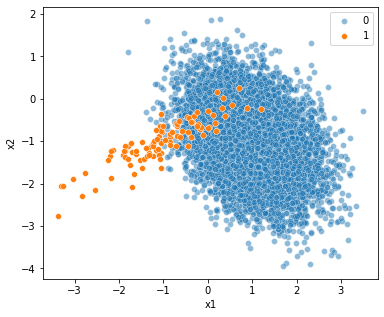

In [4]:
fig, ax1 = plt.subplots(1,1,figsize=(6,5))
majority_filter = (df['y']==0)

#ax1
g1 = sns.scatterplot(data=df[majority_filter], x='x1',y='x2',ax=ax1,alpha=0.5,label='0')
g2 = sns.scatterplot(data=df[~majority_filter], x='x1',y='x2',s=35,ax=ax1,label='1')

#labels
ax1.set_label('test')
#misc
plt.show()

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline #Make sure that the namespaces do not coincide with sklearn.


In [6]:
#define the pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X,y)

Text(0.5, 1.0, 'Data augmentation - SMOTE & random undersampling')

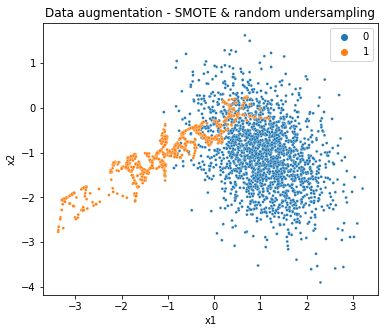

In [7]:
df = pd.DataFrame(X_res)
y = pd.Series(y_res)
df = pd.concat([df,y],axis=1)
df.columns = ['x1', 'x2','y']
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(data=df, x='x1',y='x2',hue=y,s=8)
ax.set_title('Data augmentation - SMOTE & random undersampling')

**The original SMOTE paper recommends combining SMOTE with random undersampling of the majority class**

In [8]:
over = SMOTE(sampling_strategy = 0.1)
under= RandomUnderSampler(sampling_strategy=0.5)
steps = [('over',over), ('under',under)]
pipeline = Pipeline(steps=steps)

In [9]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

In [10]:
X, y = pipeline.fit_resample(X, y)

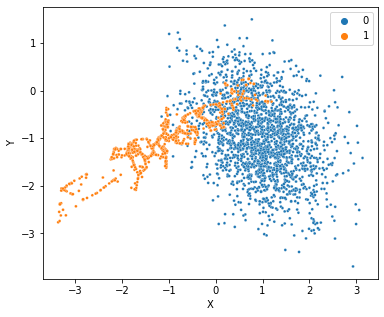

In [11]:
df = pd.DataFrame(X)
y = pd.Series(y)
df = pd.concat([df,y],axis=1)
df.columns = ['X', 'Y','y']
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(data=df, x='X',y='Y',hue=y,s=8)

In [12]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# Vanilla

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


In [14]:
scores = cross_val_score(model,X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(f'Mean ROC AUC: {mean(scores):.3f}')

Mean ROC AUC: 0.769


BalancedBagging

In [15]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate

tree = DecisionTreeClassifier(max_features='auto')
resample_rf = BalancedBaggingClassifier(base_estimator=tree,
                                       random_state=10)
scores = cross_validate(resample_rf,
                       X,y, cv=10,
                       scoring=('roc_auc','average_precision'))
pd.DataFrame(scores)[['test_roc_auc','test_average_precision']].mean()

test_roc_auc              0.932601
test_average_precision    0.405239
dtype: float64

In [16]:
from imblearn.ensemble import BalancedRandomForestClassifier


#tree = DecisionTreeClassifier(max_features='auto')

resample_rf = BalancedRandomForestClassifier(random_state=10)
scores = cross_validate(resample_rf,
                       X,y, cv=10,
                       scoring=('roc_auc','average_precision'))
pd.DataFrame(scores)[['test_roc_auc','test_average_precision']].mean()

test_roc_auc              0.952364
test_average_precision    0.608604
dtype: float64

# Upsampling SMOTE

In [17]:
#Data prep
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
#prepare the pipeline
over = SMOTE(sampling_strategy = 0.1)
steps=(('Over',over),('cls',DecisionTreeClassifier()))
pipeline = Pipeline(steps=steps)
#evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=10,random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv,n_jobs=-1)
print(f'Mean ROC AUC: {mean(scores):.3f}')

Mean ROC AUC: 0.808


# UP & Downsampling

In [18]:
#Dataprep
X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
#Pipeline
steps = [('over',over),('under',under),('cls',DecisionTreeClassifier())]
pipeline=Pipeline(steps=steps)
#Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1,scoring='roc_auc')
print(f'Mean ROC AUC: {mean(scores):.3f}')


Mean ROC AUC: 0.882


# Up & Downsampling + Balanced RandomForest

In [19]:
#Dataprep
X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
#Pipeline
steps = [('over',over),('under',under),('cls',BalancedRandomForestClassifier(random_state=10))]
pipeline=Pipeline(steps=steps)
#Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1,scoring='roc_auc')
print(f'Mean ROC AUC: {mean(scores):.3f}')

scores = cross_validate(pipeline,
                       X,y, cv=10,
                       scoring=('roc_auc','average_precision'))
pd.DataFrame(scores)[['test_roc_auc','test_average_precision']].mean()

Mean ROC AUC: 0.965


test_roc_auc              0.964283
test_average_precision    0.533789
dtype: float64

In [20]:
scores

{'fit_time': array([0.41084194, 0.37232995, 0.30107284, 0.30153179, 0.3052783 ,
        0.30102515, 0.29844785, 0.28350115, 0.28081799, 0.49193192]),
 'score_time': array([0.01779318, 0.01555514, 0.0136981 , 0.01547503, 0.01718473,
        0.01547694, 0.01351309, 0.01356697, 0.0172019 , 0.02367425]),
 'test_roc_auc': array([0.93767677, 0.98494949, 0.97252525, 0.98090909, 0.97368687,
        0.96277778, 0.8769697 , 0.98626263, 0.9729798 , 0.99409091]),
 'test_average_precision': array([0.2777561 , 0.53938068, 0.59026937, 0.4779526 , 0.6449223 ,
        0.47898724, 0.2648414 , 0.58194761, 0.90333333, 0.57849822])}

# Use loop for find best k in kNN

In [21]:
kvalues = [1,2,3,4,5,6,7,8,9]
for k in kvalues:
    #Dataprep
    X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant=0,
                               n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    #Pipeline
    steps = [('over',over),('under',under),('cls',DecisionTreeClassifier())]
    pipeline=Pipeline(steps=steps)
    #Evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1,scoring='roc_auc')
    print(f'Mean ROC AUC: {mean(scores):.3f} using {k} nearest neighbours')

Mean ROC AUC: 0.844 using 1 nearest neighbours
Mean ROC AUC: 0.857 using 2 nearest neighbours
Mean ROC AUC: 0.863 using 3 nearest neighbours
Mean ROC AUC: 0.878 using 4 nearest neighbours
Mean ROC AUC: 0.871 using 5 nearest neighbours
Mean ROC AUC: 0.879 using 6 nearest neighbours
Mean ROC AUC: 0.872 using 7 nearest neighbours
Mean ROC AUC: 0.862 using 8 nearest neighbours
Mean ROC AUC: 0.870 using 9 nearest neighbours


# Smote with selective synthetic sample generation

# Borderline-SMOTE
Focus on selecting instances of minority class that are misclassified, such as with a k-nearest neighbor classification model

In [22]:
from imblearn.over_sampling import BorderlineSMOTE

#prep data
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)


Text(0.5, 1.0, 'Original Dataset')

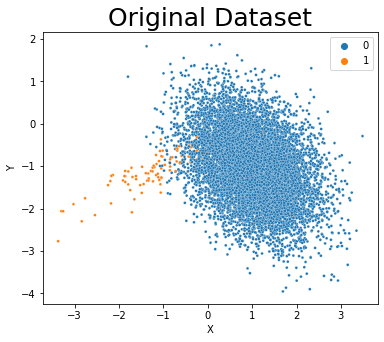

In [23]:
df = pd.DataFrame(X)
y = pd.Series(y)
df = pd.concat([df,y],axis=1)
df.columns = ['X', 'Y','y']
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(data=df, x='X',y='Y',hue=y,s=8)
g.set_title('Original Dataset',size=25)

Text(0.5, 1.0, 'BORDERLINE-1')

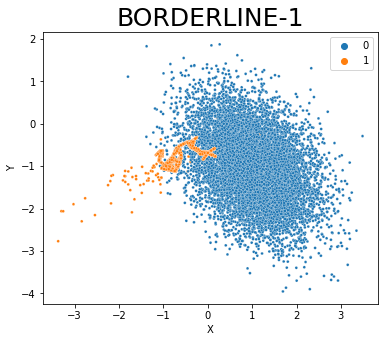

In [24]:
oversample = BorderlineSMOTE(kind='borderline-1')
X,y = oversample.fit_resample(X,y)

df = pd.DataFrame(X)
y = pd.Series(y)
df = pd.concat([df,y],axis=1)
df.columns = ['X', 'Y','y']
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(data=df, x='X',y='Y',hue=y,s=8)
g.set_title('BORDERLINE-1', size=25)

In [25]:
pd.Series(y).value_counts()

1    9900
0    9900
dtype: int64

In [26]:
#prep data
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

Text(0.5, 1.0, 'BORDERLINE-2')

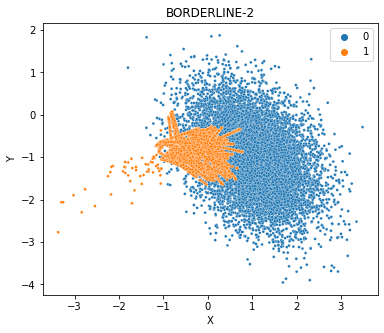

In [27]:
oversample = BorderlineSMOTE(kind='borderline-2')
X,y = oversample.fit_resample(X,y)

df = pd.DataFrame(X)
y = pd.Series(y)
df = pd.concat([df,y],axis=1)
df.columns = ['X', 'Y','y']
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(data=df, x='X',y='Y',hue=y,s=8)
g.set_title('BORDERLINE-2')

# Borderline-SMOTE SVM
Swapping kNN for SVM algorithm to identify misclassified examples on the decision boundary.

In [28]:
#prep data
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

In [29]:
from imblearn.over_sampling import SVMSMOTE

oversample=SVMSMOTE()
X,y = oversample.fit_resample(X,y)

In [30]:
df = pd.DataFrame(X)
y = pd.Series(y)
df = pd.concat([df,y],axis=1)
df.columns=['X','Y','y']

Text(0.5, 1.0, 'SVMSMOTE')

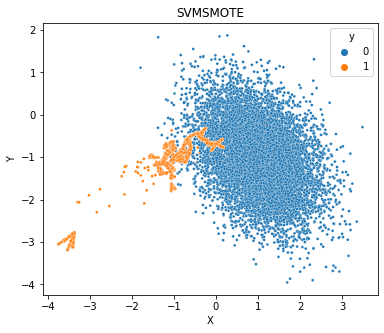

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(x='X',y='Y',hue='y',data=df,s=8)
g.set_title('SVMSMOTE')

In [32]:
df['y'].value_counts()

1    9900
0    9900
Name: y, dtype: int64

# ADASYN

In [33]:
#prep data
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=10)

In [34]:
from imblearn.over_sampling import ADASYN
oversample=ADASYN()
X,y = oversample.fit_resample(X,y)

In [35]:
df = pd.DataFrame(X)
y = pd.Series(y)
df = pd.concat([df,y],axis=1)
df.columns=['X','Y','y']

Text(0.5, 1.0, 'ADASYN')

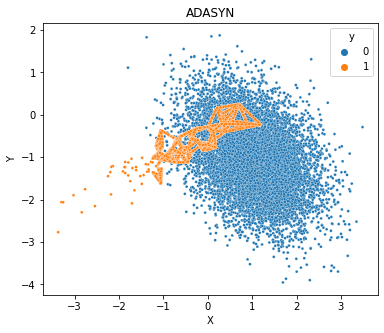

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
g = sns.scatterplot(x='X',y='Y',hue='y',data=df,s=8)
g.set_title('ADASYN')

In [37]:
df['y'].value_counts()

0    9900
1    9892
Name: y, dtype: int64

In [38]:
X,y = make_classification(n_samples=1000,n_features=2,n_redundant=0,
                          n_clusters_per_class = 1, weights = [0.95],
                          flip_y=0,random_state=10)

In [39]:
df = pd.DataFrame(X,columns=['x1','x2'])
df = pd.concat([df,pd.Series(y,name='y')],axis=1)

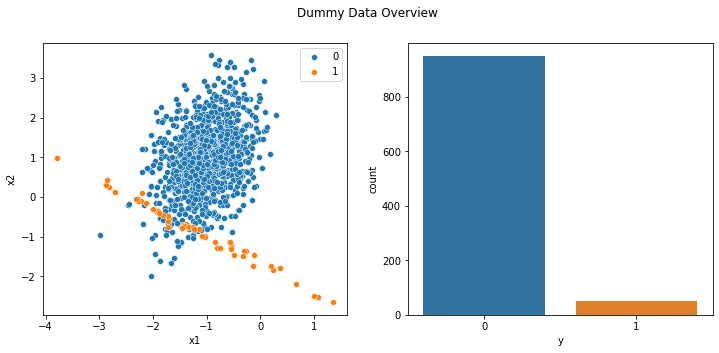

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

#Create a mask to later do layered plotting.
minority = (df['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#First axis
g1 = sns.scatterplot(x='x1',y='x2',data=df[majority],ax=ax1,label='0')
g2 = sns.scatterplot(x='x1',y='x2',data=df[minority],ax=ax1,label='1')

#Second axis
g3 = sns.countplot(x='y',data=df,ax=ax2)



fig.suptitle('Dummy Data Overview')
plt.tight_layout
plt.show()


In [41]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = under.fit_resample(X,y)

In [42]:
df_under = pd.concat([pd.DataFrame(X_under, columns=['x1','x2']),pd.Series(y_under,name='y')],axis=1)

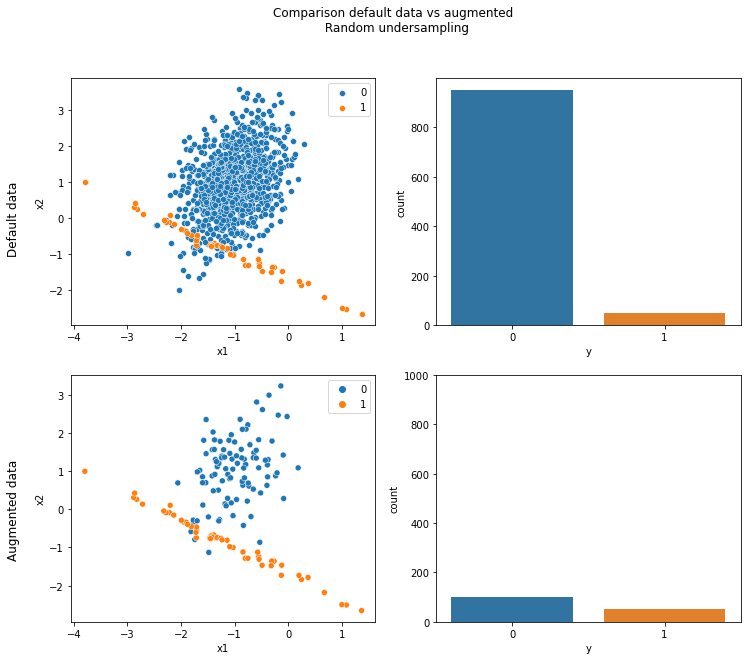

In [43]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))

#Create a mask to later do layered plotting.
minority = (df['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#1.1
g1 = sns.scatterplot(x='x1',y='x2',data=df[majority],ax=ax1,label='0')
g1 = sns.scatterplot(x='x1',y='x2',data=df[minority],ax=ax1,label='1')

#1.2
g2 = sns.countplot(x='y',data=df,ax=ax2)


#2.1
g3 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_under,ax=ax3)
g3.legend()

#2.2
g4 = sns.countplot(x='y',data=df_under,ax=ax4)
g4.set_ylim(0,1000)


#
ax1.annotate('Default data',xy=(0,0),xytext=(-5,0),size='large',
             ha='right',va='center',rotation=90)

ax3.annotate('Augmented data',xy=(0,0),xytext=(-5,0),size='large',
             ha='right',va='center',rotation=90)


fig.suptitle('Comparison default data vs augmented \n Random undersampling')
plt.savefig(path / 'jpg' / 'Comparison_orig_rand_undersamp.jpg')
plt.show()

# Upsampling using SMOTE

In [44]:
X,y = make_classification(n_samples=1000,n_features=2,n_redundant=0,
                          n_clusters_per_class = 1, weights = [0.95],
                          flip_y=0,random_state=10)

In [45]:
over = SMOTE(sampling_strategy=1)
X_over,y_over = over.fit_resample(X,y)

In [46]:
df_over = pd.concat([pd.DataFrame(X_over,columns=['x1','x2']),pd.Series(y_over,name='y')],axis=1)

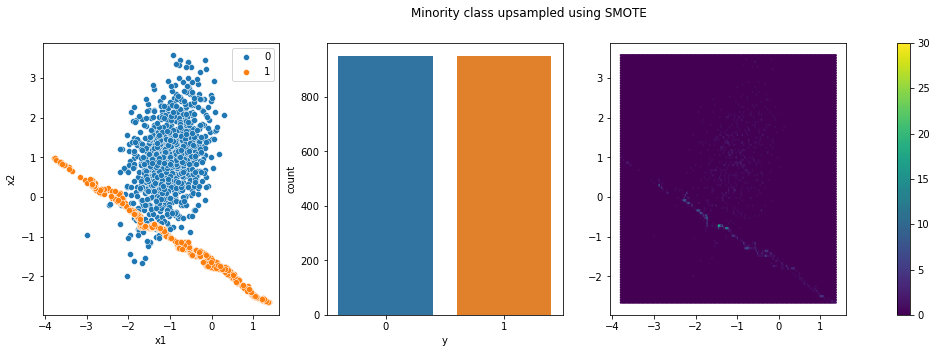

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
#Create a mask to later do layered plotting.
minority = (df_over['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#Plot 1,1
g1 = sns.scatterplot(x='x1',y='x2',data=df_over[majority],ax=ax1, label='0') #Majority class first
g2 = sns.scatterplot(x='x1',y='x2',data=df_over[minority],ax=ax1, label='1') #Minority 

#Plot 1,2
g3 = sns.countplot(x='y',data=df_over,ax=ax2)

#
im = ax3.hexbin(x='x1',y='x2',data=df_over,
                vmin=0,vmax=30,gridsize=170)


fig.colorbar(im,ax=[ax1,ax2,ax3])

fig.suptitle('Minority class upsampled using SMOTE')
plt.show()

# New SMOTE

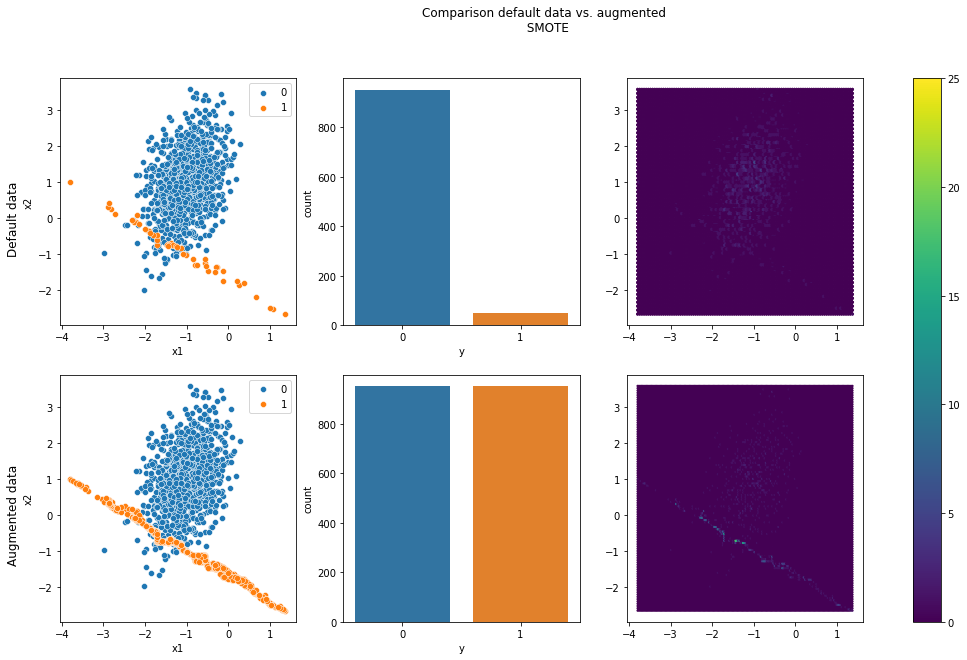

In [48]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,10))

#Create a mask to later do layered plotting.
minority = (df['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#1,1
g1 = sns.scatterplot(x='x1',y='x2',data=df[majority],ax=ax1,label='0')
g2 = sns.scatterplot(x='x1',y='x2',data=df[minority],ax=ax1,label='1')

#1,2
g3 = sns.countplot(x='y',data=df,ax=ax2)

#1,3
g4 = ax3.hexbin(x='x1',y='x2',data=df,vmin=0,vmax=25)

#2,1

#Create a mask to later do layered plotting.
minority = (df_over['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#Plot 1,1
g1 = sns.scatterplot(x='x1',y='x2',data=df_over[majority],ax=ax4, label='0') #Majority class first
g2 = sns.scatterplot(x='x1',y='x2',data=df_over[minority],ax=ax4, label='1') #Minority 

#Plot 1,2
g3 = sns.countplot(x='y',data=df_over,ax=ax5)

#
im = ax6.hexbin(x='x1',y='x2',data=df_over,
                vmin=0,vmax=25,gridsize=170)

ax1.annotate('Default data',xy=(0,0),xytext=(-5,0),size='large',
             ha='right',va='center',rotation=90)
ax4.annotate('Augmented data',xy=(0,0),xytext=(-5,0),size='large',
             ha='right',va='center',rotation=90)

##
'''
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
'''
fig.colorbar(im, ax=[ax1,ax2,ax3,ax4,ax5,ax6])


fig.suptitle('Comparison default data vs. augmented \n SMOTE')
plt.savefig(path / 'jpg' / 'Comparison_orig_SMOTE_upsampling.jpg')
plt.show()


# Random upsampling

In [49]:
from imblearn.over_sampling import RandomOverSampler


X,y = make_classification(n_samples=1000,n_features=2,n_redundant=0,
                          n_clusters_per_class = 1, weights = [0.95],
                          flip_y=0,random_state=10)

In [50]:
Random_over = RandomOverSampler(sampling_strategy = 1)
X_over,y_over = Random_over.fit_resample(X,y)

In [51]:
df_over = pd.concat([pd.DataFrame(X_over,columns=['x1','x2']),pd.Series(y_over,name='y')],axis=1)

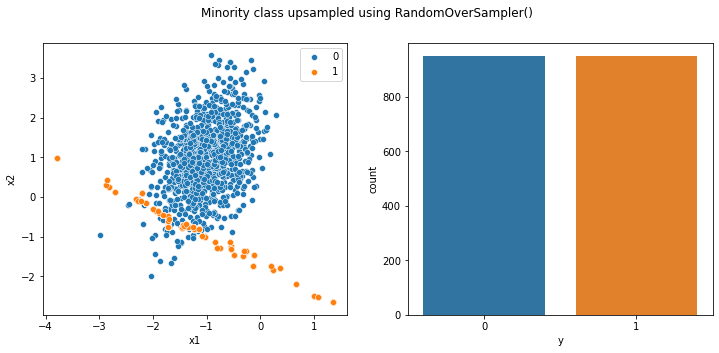

In [52]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
#Create a mask to later do layered plotting.
minority = (df_over['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#Plot 1,1
g1 = sns.scatterplot(x='x1',y='x2',data=df_over[majority],ax=ax1, label='0') #Majority class first
g2 = sns.scatterplot(x='x1',y='x2',data=df_over[minority],ax=ax1, label='1') #Minority 

#Plot 1,2
g3 = sns.countplot(x='y',data=df_over,ax=ax2)

fig.suptitle('Minority class upsampled using RandomOverSampler()')
plt.show()

# Compare original dataset to higher densitiy random oversampling

In [53]:
X,y = make_classification(n_samples=1000,n_features=2,n_redundant=0,
                          n_clusters_per_class = 1, weights = [0.95],
                          flip_y=0,random_state=10)

df = pd.DataFrame(X,columns=['x1','x2'])
df = pd.concat([df,pd.Series(y,name='y')],axis=1)

In [54]:
Random_over = RandomOverSampler(sampling_strategy = 1)
X_over_random,y_over_random = Random_over.fit_resample(X,y)
df_over_random = pd.concat([pd.DataFrame(X_over_random,columns=['x1','x2']),pd.Series(y_over,name='y')],axis=1)

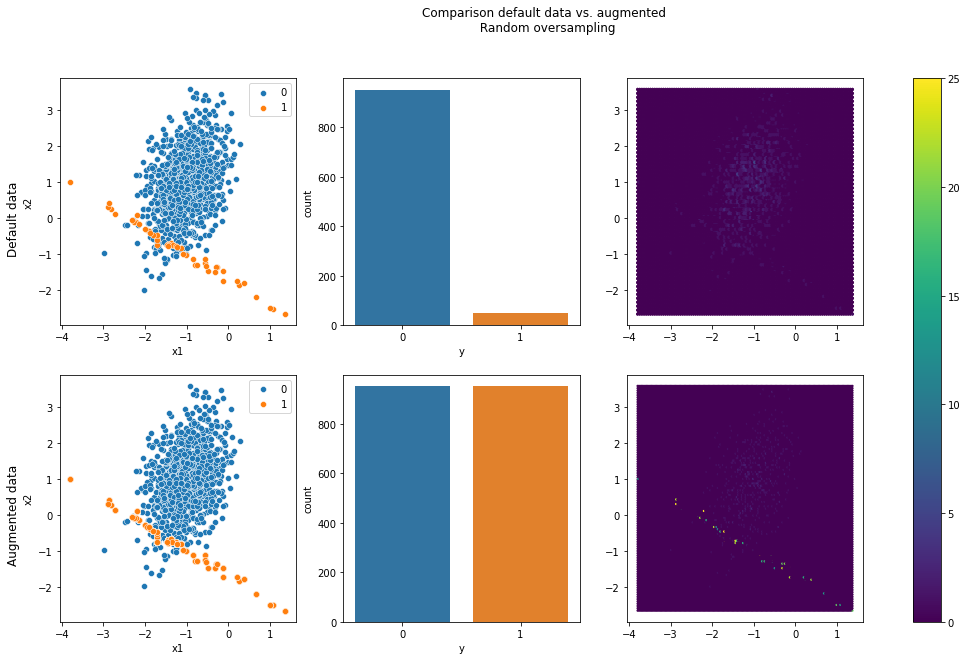

In [55]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,10))

#Create a mask to later do layered plotting.
minority = (df['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#1,1
g1 = sns.scatterplot(x='x1',y='x2',data=df[majority],ax=ax1,label='0')
g2 = sns.scatterplot(x='x1',y='x2',data=df[minority],ax=ax1,label='1')

#1,2
g3 = sns.countplot(x='y',data=df,ax=ax2)

#1,3
g4 = ax3.hexbin(x='x1',y='x2',data=df,vmin=0,vmax=25)

#2,1

#Create a mask to later do layered plotting.
minority = (df_over_random['y']==1)
majority = ~minority #Complement to the minority filter, i.e the majority

#2,1
g5 = sns.scatterplot(x='x1',y='x2',data=df_over_random[majority],ax=ax4, label='0') #Majority class first
g6 = sns.scatterplot(x='x1',y='x2',data=df_over_random[minority],ax=ax4, label='1') #Minority 

#2,2
g7 = sns.countplot(x='y',data=df_over_random,ax=ax5)

#2,3
#im = ax6.hexbin(x='x1',y='x2',data=df_over_random,
#                vmin=0,vmax=25,gridsize=100)
im = ax6.hexbin(x='x1',y='x2',data=df_over_random,vmin=0,vmax=25,gridsize=170)


##
'''
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
'''
fig.colorbar(im, ax=[ax1,ax2,ax3,ax4,ax5,ax6])
#ax1.set_ylabel('Original data', rotation=90, size='large')
#ax4.set_ylabel('Augmented data', rotation=90, size='large')
ax1.annotate('Default data',xy=(0,0),xytext=(-5,0),size='large',
             ha='right',va='center',rotation=90)
ax4.annotate('Augmented data',xy=(0,0),xytext=(-5,0),size='large',
             ha='right',va='center',rotation=90)


fig.suptitle('Comparison default data vs. augmented \n Random oversampling')
plt.savefig(path / 'jpg' / 'Comparison_orig_rand_oversamp.jpg')
plt.show()


# Pipeline over/under sample

In [56]:
over_smote = SMOTE(sampling_strategy=0.4)
under_random = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over', over_smote), ('under', under_random)]
pipeline = Pipeline(steps=steps)

X_, y_ = pipeline.fit_resample(X,y)

In [57]:
df_pipe = pd.concat([pd.DataFrame(X_,columns=['x1','x2']),pd.Series(y_,name='y')],axis=1)

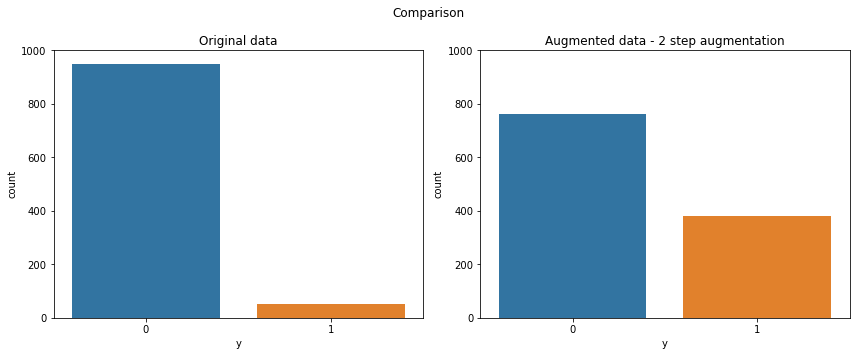

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='y',data=df,ax=ax1)
sns.countplot(x='y',data=df_pipe,ax=ax2)

ax1.set(ylim=(0, 1000))
ax2.set(ylim=(0, 1000))
ax1.set_title('Original data')
ax2.set_title('Augmented data - 2 step augmentation')
fig.suptitle('Comparison')
plt.tight_layout()
plt.savefig(path / 'jpg' / 'Pipelinesequence.jpg')

# Misc SMOTE algorithms


In [59]:
X,y = make_classification(n_samples=1000,n_features=2,n_redundant=0,
                          n_clusters_per_class = 1, weights = [0.95],
                          flip_y=0,random_state=1)

In [60]:
#train classifier
steps = [('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf_orig = pipeline.fit(X,y)

In [61]:
df_orig = pd.concat([pd.DataFrame(X,columns=['x1','x2']),pd.Series(y,name='y')],axis=1)

In [62]:
#Original SMOTE
oversample_smote = SMOTE()
X_smote,y_smote = oversample_smote.fit_resample(X,y)

#train classifier
steps = [('over',oversample_smote),('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf_smote = pipeline.fit(X_smote,y_smote)

#
df_smote = pd.concat([pd.DataFrame(X_smote,columns=['x1','x2']),pd.Series(y_smote,name='y')],axis=1)

In [63]:
#Borderline1
oversample_bl_one = BorderlineSMOTE(kind='borderline-1')
X_bl_one,y_bl_one = oversample_bl_one.fit_resample(X,y)

#train classifier
steps = [('over',oversample_bl_one),('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf_bl_one = pipeline.fit(X_bl_one, y_bl_one)

df_over_bl_one = pd.concat([pd.DataFrame(X_bl_one,columns=['x1','x2']),pd.Series(y_bl_one,name='y')],axis=1)

In [64]:
#Borderline2
oversample_bl_2 = BorderlineSMOTE(kind='borderline-2')
X_bl_2,y_bl_2 = oversample_bl_2.fit_resample(X,y)

#train classifier
steps = [('over',oversample_bl_2),('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf_bl_2 = pipeline.fit(X_bl_2, y_bl_2)

df_over_bl_2 = pd.concat([pd.DataFrame(X_bl_2,columns=['x1','x2']),pd.Series(y_bl_2,name='y')],axis=1)

In [65]:
#SVMSMOTE
oversample_svm = SVMSMOTE()
X_svm,y_svm = oversample_svm.fit_resample(X,y)

#train classifier
steps = [('over',oversample_svm),('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf_svm = pipeline.fit(X_svm, y_svm)

df_svm = pd.concat([pd.DataFrame(X_svm,columns=['x1','x2']),pd.Series(y_svm,name='y')],axis=1)

In [66]:
#ADASYN
oversample_adasyn = ADASYN()
X_ada,y_ada = oversample_adasyn.fit_resample(X,y)

#train classifier
steps = [('over',oversample_adasyn),('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf_ada = pipeline.fit(X_ada, y_ada)

df_ada = pd.concat([pd.DataFrame(X_ada,columns=['x1','x2']),pd.Series(y_ada,name='y')],axis=1)

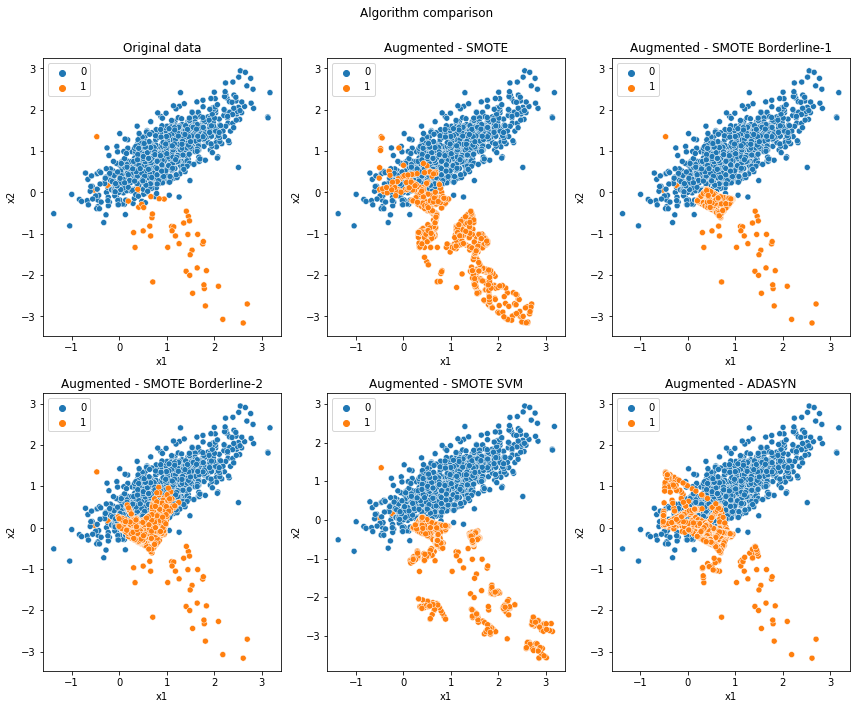

In [67]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,10))

#1.1 Original data
g1 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_orig,ax=ax1)
g1.legend()

#1.2 SMOTE
g2 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_smote,ax=ax2)
g2.legend()

#1,3 Borderline_1
g3 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_over_bl_one,ax=ax3)
g3.legend()

#2,1
g4 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_over_bl_2,ax=ax4)
g4.legend()

#2,2
g5 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_svm,ax=ax5)
g5.legend()

#2,3
g6 = sns.scatterplot(x='x1',y='x2',hue='y',data=df_ada,ax=ax6)
g6.legend()

#ax adjustments
ax1.set_title('Original data')
ax2.set_title('Augmented - SMOTE')
ax3.set_title('Augmented - SMOTE Borderline-1')
ax4.set_title('Augmented - SMOTE Borderline-2')
ax5.set_title('Augmented - SMOTE SVM')
ax6.set_title('Augmented - ADASYN')

#Figure & misc
fig.suptitle('Algorithm comparison \n')
plt.savefig(path / 'jpg' / 'Comparison_orig_SMOTE_Extensions.jpg')
plt.tight_layout()
plt.show()


In [68]:
#https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

# Decision boundaries


steps = [('over',over),('under',under),('cls',SVC(kernel='rbf'))]
pipeline = Pipeline(steps = steps)
clf = pipeline.fit(X,y)


score = cross_val_score(pipeline, X, y, cv=cv,scoring='roc_auc')
print(f'{mean(score):.3f}')

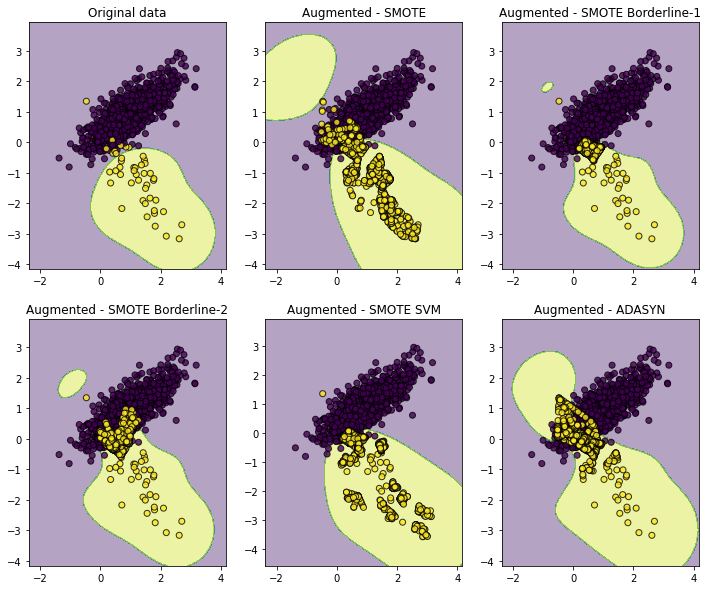

In [69]:
import numpy as np
from sklearn.svm import SVC
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,10))

#1
plot_decision_function(X, y, clf_orig, ax=ax1)

#2
plot_decision_function(X_smote, y_smote, clf_smote, ax=ax2)

#3
plot_decision_function(X_bl_one, y_bl_one, clf_bl_one, ax=ax3)

#4
plot_decision_function(X_bl_2, y_bl_2, clf_bl_2, ax=ax4)

#5
plot_decision_function(X_svm, y_svm, clf_svm, ax=ax5)

#6
plot_decision_function(X_ada, y_ada, clf_ada, ax=ax6)

#
ax1.set_title('Original data')
ax2.set_title('Augmented - SMOTE')
ax3.set_title('Augmented - SMOTE Borderline-1')
ax4.set_title('Augmented - SMOTE Borderline-2')
ax5.set_title('Augmented - SMOTE SVM')
ax6.set_title('Augmented - ADASYN')

plt.savefig(path / 'jpg' / 'Visual_decisionboundary_smote_extensions.jpg')